### Importing libraries

In [1]:
import openpyxl as op
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
import numpy as np
import pandas as pd
from openpyxl import Workbook
import re
from IPython.display import set_matplotlib_formats
from matplotlib.patches import Patch, PathPatch
import collections
import plotly.graph_objects as go
import os
import glob
import plotly.express as px
import statistics
from enum import auto

### Loading affected protein block summary table

In [2]:
pblocks = pd.read_excel('../B_hybrid_aln_results_toy/pblock-table/pblocks_hybrid_align_table.xlsx')

In [3]:
class CTerminalChange():
    SPLICING = auto()
    FRAMESHIFT = auto()
    ALTERNATIVE_ORF = auto()
    UNKNOWN = auto()

class NTerminalChange():
    MUTUALLY_EXCLUSIVE = auto()
    DOWNSTREAM_SHARED = auto()
    UPSTREAM_SHARED = auto()
    MUTUALLY_SHARED = auto()
    ALTERNATIVE_ORF = auto()
    UNKNOWN = auto()

### Plot 1: 

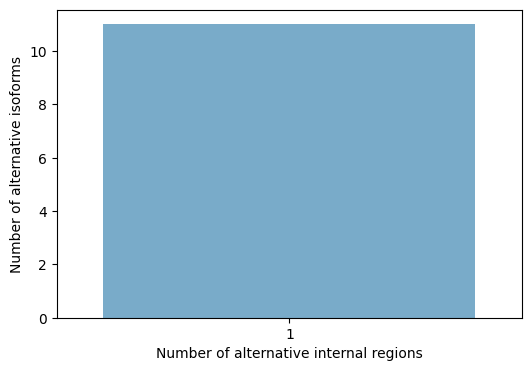

In [11]:
internal_pblocks = (
    pblocks[pblocks['nterm'].isna() & pblocks['cterm'].isna()].
    drop(columns=[col for col in pblocks.columns if 'start' in col or 'stop' in col]).
    copy()
)
internal_pblocks['category'] = (
    internal_pblocks['cblocks'].
    apply(lambda cblocks: ''.join(cblock[0] for cblock in cblocks)).
    str.replace(r'[ex]', '', regex=True).
    map({'d': 'D', 'i': 'I'}).
    fillna('S')
)
# works when level=0 (initially was 3)
internal_pblock_counts = internal_pblocks.reset_index(level=3).groupby(['anchor', 'other']).agg(pblocks=('pblock', 'count'))

internal_pblock_counts_fig = plt.figure(figsize=(6, 4))
ax = sns.countplot(data=internal_pblock_counts, x='pblocks', palette='Blues_r')
ax.set(xlabel='Number of alternative internal regions', ylabel='Number of alternative isoforms')
plt.savefig('../F_internal_region_plots/internal-pblock-counts.svg', dpi=200, facecolor=None)

### Plot 2: 

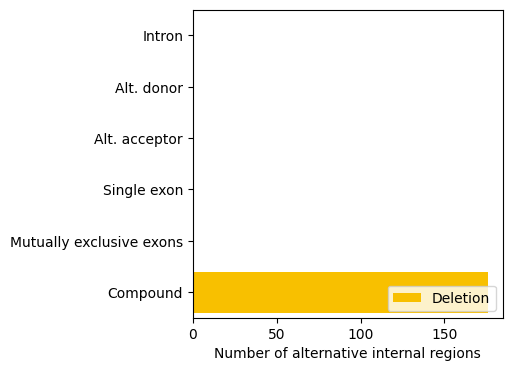

In [12]:
internal_cat_palette = {'D': '#f800c0', 'I': '#00c0f8', 'S': '#f8c000'}
internal_event_palette = {
    'Intron': '#e69138',
    'Alt. donor': '#6aa84f',
    'Alt. acceptor': '#8a4ea7',
    'Single exon': '#3d85c6',
    'Mutually exclusive exons': '#255179',
    'Compound': '#888888'
}

internal_subcats = pd.DataFrame(
    {
        'Intron': internal_pblocks['tblock_events'].isin({('I',), ('i',)}),
        'Alt. donor': internal_pblocks['tblock_events'].isin({('D',), ('d',)}),
        'Alt. acceptor': internal_pblocks['tblock_events'].isin({('A',), ('a',)}),
        'Single exon': internal_pblocks['tblock_events'].isin({('E',), ('e',)}),
        'Mutually exclusive exons': internal_pblocks['tblock_events'].isin({('E', 'e'), ('e', 'E')}),
        'Compound': [True for _ in internal_pblocks.index]
    }
)
internal_pblocks['splice event'] = internal_subcats.idxmax(axis=1).astype(pd.CategoricalDtype(internal_subcats.columns, ordered=True))

internal_pblocks_fig = plt.figure(figsize=(4, 4))
ax = sns.countplot(
    data = internal_pblocks.sort_values('category', ascending=True),
    y = 'splice event',
    hue = 'category',
    palette = internal_cat_palette,
    saturation = 1,
    dodge = True,
)
plt.legend(loc='lower right', labels=['Deletion', 'Insertion', 'Substitution'])
ax.set(xlabel='Number of alternative internal regions', ylabel=None)
plt.savefig('../F_internal_region_plots/internal-pblock-events.svg', dpi=200, facecolor=None, bbox_inches='tight')

### Plot 3: 

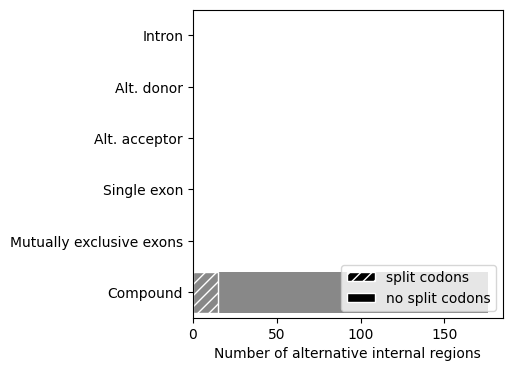

In [13]:

# %%
internal_pblocks_split_fig = plt.figure(figsize=(4, 4))
ax = sns.countplot(
    data = internal_pblocks.sort_values('category', ascending=True),
    y = 'splice event',
    palette = internal_event_palette,
    saturation = 1,
)
sns.countplot(
    ax = ax,
    data = internal_pblocks[internal_pblocks.split_ends].sort_values('category', ascending=True),
    y = 'splice event',
    fill = False,
    edgecolor = 'w',
    hatch = '///',
)
plt.legend(loc='lower right', handles=[Patch(facecolor='k', edgecolor='w', hatch='///'), Patch(facecolor='k', edgecolor='w')], labels=['split codons', 'no split codons'])
ax.set(xlabel='Number of alternative internal regions', ylabel=None)
plt.savefig('../F_internal_region_plots/internal-pblock-events-split.svg', dpi=200, facecolor=None, bbox_inches='tight')

# %%


### Plot 4

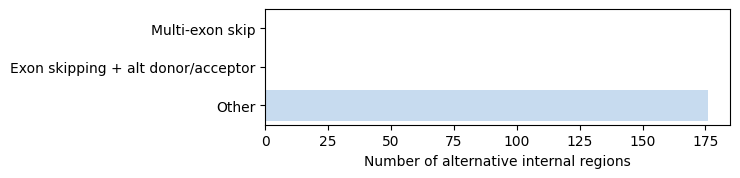

In [14]:
internal_compound_pblocks = internal_pblocks[internal_pblocks['splice event'] == 'Compound'].copy()

internal_compound_subcats = pd.DataFrame(
    {
        'Multi-exon skip': internal_compound_pblocks['events'] == {'e'},
        'Exon skipping + alt donor/acceptor': internal_compound_pblocks['events'].isin({
            frozenset('de'),
            frozenset('De'),
            frozenset('ea'),
            frozenset('eA'),
            frozenset('dea'),
            frozenset('Dea'),
            frozenset('deA'),
            frozenset('DeA'),
        }),
        'Other': [True for _ in internal_compound_pblocks.index]
    }
)
internal_compound_pblocks['compound_subcat'] = internal_compound_subcats.idxmax(axis=1).astype(pd.CategoricalDtype(internal_compound_subcats.columns, ordered=True))

internal_pblocks_compound_fig = plt.figure(figsize=(6, 1.5))
ax = sns.countplot(
        data = internal_compound_pblocks,
        y = 'compound_subcat',
        palette = 'Blues_r',
        saturation = 1,
        linewidth = 0,
)
ax.set(xlabel='Number of alternative internal regions', ylabel=None)
plt.savefig('../F_internal_region_plots/internal-pblock-compound-events.svg', dpi=200, facecolor=None, bbox_inches='tight')